In [52]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import numpy as np
from scipy.signal import butter, filtfilt
import librosa

import matplotlib.pyplot as plt

In [53]:
import pywt
print("The wavelet functions we can use:")
print(pywt.wavelist())

USE_WAVELET = "None"



The wavelet functions we can use:
['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'haar', 'mexh', 'morl', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5'

In [231]:
class CustomDataset(Dataset):
    def __init__(self, csv_path, transform=None, USE_WAVELET='db16',root = '..'):
        '''
        csv_path: path to your metadata
        \n
        USE_WAVELET:
        \n
        \t'LPF10'-> for low pass with 10 Hz \n
        \t'LPF20'-> for low pass with 20 Hz \n
        \t'USE_WAVELET'-> use other default wavelets \n
        root: path to 'hms-harmful-brain-activity-classification'
        '''

        self.metadata = pd.read_csv(csv_path)
        self.transform = transform

        self.USE_WAVELET = USE_WAVELET

        self.root = root


        self.NAMES = ['LL','LP','RP','RR']

        self.FEATS = [['Fp1','F7','T3','T5','O1'],
                ['Fp1','F3','C3','P3','O1'],
                ['Fp2','F8','T4','T6','O2'],
                ['Fp2','F4','C4','P4','O2']]


    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        
        retSpecs,retEEGs,ogEEGS,consensus, labels = self.spectrogram_from_eeg(1)

        if self.transform:
            retSpecs = self.transform(retSpecs)

        return retSpecs, labels
    


    def spectrogram_from_eeg(self,eeg_id, display=False):
    

        sub_id,offSets,sliced_eegs,OG_eeg,consensus, labels = self.getWindowsfromEEG(eeg_id)
        eeg = sliced_eegs[0]
        
        
        if display: plt.figure(figsize=(10,7))

        retSpecs = []
        retEEGs = []
        ogEEGs = []

        img = np.zeros((128,128),dtype='float32')
        signals = []
        signalsX = []
        signalsXOG = []
        for k in range(4):
            COLS = self.FEATS[k]

            tempSpec= np.zeros((128,128))

            if self.USE_WAVELET=="LPF10" or self.USE_WAVELET=="LPF20" or self.USE_WAVELET == "None":
                temp = np.zeros((2001))
                tempOG = np.zeros((2001))
            else:
                temp = np.zeros((2002))
                tempOG = np.zeros((2001))
            
            for kk in range(4):
            
        
                x = eeg[COLS[kk]] - eeg[COLS[kk+1]]
                tempOG+=x
        
                m = np.nanmean(x)
                if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
                else: x[:] = 0

                
                if self.USE_WAVELET=='LPF10':
            
                    x = self.apply_lpf(x,cutoff_freq=10)
                elif self.USE_WAVELET=='LPF20':
            
                    x = self.apply_lpf(x,cutoff_freq=20)
                else:
                    x = self.denoise(x, wavelet=self.USE_WAVELET)

                temp+=x
                signals.append(x)
                



                mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//128, 
                    n_fft=1024, n_mels=128, fmin=0, fmax=20, win_length=128)

        
                width = (mel_spec.shape[1]//32)*32
                
                mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]

        
                mel_spec_db = (mel_spec_db+40)/40 



                # if mel_spec_db.shape[1] < 512:
                #     pad_width = ((0, 0), (0, 512 - mel_spec_db.shape[1]))
                #     mel_spec_db = np.pad(mel_spec_db, pad_width=pad_width, mode='constant', constant_values=0)
                # elif mel_spec_db.shape[1] > 512:
                #     mel_spec_db = mel_spec_db[:, :512]

                # print(tempSpec.shape,mel_spec_db.shape)

                tempSpec += mel_spec_db
            temp/=4.0
            tempOG/=4.0
            
            signalsX.append(temp)    
            signalsXOG.append(tempOG)


            tempSpec /= 4.0

            img  = np.vstack((img,tempSpec))


        retSpecs.append(img[128:])

        retEEGs.append(np.array(signalsX))
        ogEEGs.append(np.array(signalsXOG))


        return np.array(retSpecs[0]),np.array(retEEGs),np.array(ogEEGs), consensus, labels

    def getWindowsfromEEG(self,loc):

        labelMap = {'Seizure':0,'GPD':1,'LRDA':2,'Other':3,'GRDA':4,'LPD':5}

        subSet = self.metadata.iloc[loc]
        eeg_id = subSet['eeg_id']

        labels = np.array([int(subSet['seizure_vote']), int(subSet['lpd_vote']) , int(subSet['gpd_vote'])
                        ,int(subSet['lrda_vote']), int(subSet['grda_vote']), int(subSet['other_vote'])])

        consensus = labelMap[subSet['expert_consensus']]

        eeg = pd.read_parquet(f'{self.root}/train_eegs/{eeg_id}.parquet')

        fs = 200
        eeg["time"] = eeg.index / fs
        eeg.set_index("time", inplace=True)
        eeg.index

        offSet = int(subSet['eeg_label_offset_seconds'])

        toRet = []

        toRet.append(eeg.loc[offSet+20:offSet+30])
        return int(subSet['eeg_sub_id']),offSet,toRet,eeg,np.array(consensus), np.array(labels)

    def apply_lpf(self,data, sampling_rate=200, cutoff_freq=10, order=5):

        nyquist_freq = 0.5 * sampling_rate
        normal_cutoff = cutoff_freq / nyquist_freq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        filtered_data = filtfilt(b, a, data)

        return filtered_data

    def maddest(self,d, axis=None):
        return np.mean(np.absolute(d - np.mean(d, axis)), axis)

    def denoise(self,x, wavelet='haar', level=1):    
        coeff = pywt.wavedec(x, wavelet, mode="per")
        sigma = (1/0.6745) * self.maddest(coeff[-level])

        uthresh = sigma * np.sqrt(2*np.log(len(x)))
        coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

        ret=pywt.waverec(coeff, wavelet, mode='per')
        
        return ret


In [232]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512,512))
])


batch_size = 4

train_path = 'hms-harmful-brain-activity-classification/train_mine.csv'
test_path = 'hms-harmful-brain-activity-classification/test_mine.csv'
val_path = 'hms-harmful-brain-activity-classification/val_mine.csv'
root = '/Users/anishpawar/MTech/Sem-2/IVP/Project_PreProc_Final_Report/hms-harmful-brain-activity-classification'



train_dataset = CustomDataset(csv_path=train_path, transform=transform,root=root,USE_WAVELET='LPF10')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


test_dataset = CustomDataset(csv_path=test_path, transform=transform,root=root,USE_WAVELET='LPF10')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


val_dataset = CustomDataset(csv_path=val_path, transform=transform,root=root,USE_WAVELET='LPF10')
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


In [233]:
specs,labels = next(iter(val_loader))

In [234]:
len(train_loader)

21360

In [169]:
specs.shape

torch.Size([4, 1, 512, 512])

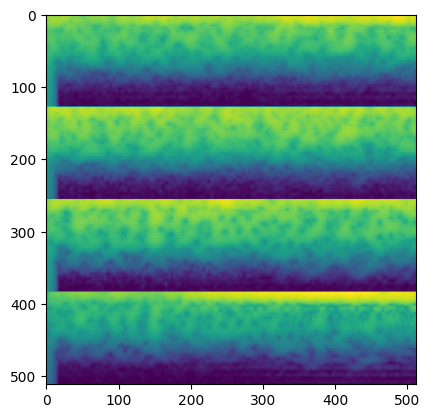

In [170]:
plt.imshow(specs[0,0,:])

In [216]:
for specs,labels in iter(train_loader) :
    print(specs.shape,labels.shape)

torch.Size([4, 1, 512, 512]) torch.Size([4, 6])
torch.Size([4, 1, 512, 512]) torch.Size([4, 6])
torch.Size([4, 1, 512, 512]) torch.Size([4, 6])
torch.Size([4, 1, 512, 512]) torch.Size([4, 6])
torch.Size([4, 1, 512, 512]) torch.Size([4, 6])


KeyboardInterrupt: 